<a href="https://colab.research.google.com/github/Gorphe/Howard-Gugger-Book/blob/main/6_Other_CV_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PASCAL_2007)

In [3]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.json')]

In [4]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


Constructing a Datablock

In [5]:
dblock = DataBlock()

In [6]:
dsets = dblock.datasets(df)

In [9]:
type(dsets)

fastai.data.core.Datasets

In [ ]:
dsets

In [13]:
dblock = DataBlock(
    get_x=lambda r: r['fname'],
    get_y=lambda r: r['labels']
    )
dsets=dblock.datasets(df)
dsets.train[0]

('004868.jpg', 'person diningtable tvmonitor')

In [15]:
def get_x(r) :
  return path/'train'/r['fname']
def get_y(r):
  return r['labels'].split(' ')

dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/004530.jpg'), ['bus', 'person'])

In [16]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y
    )
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [17]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]


(#1) ['bird']

In [18]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(
  blocks = (ImageBlock, MultiCategoryBlock),
  splitter=splitter,
  get_x=get_x,
  get_y=get_y  
)

dsets=dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [19]:
dblock = DataBlock(
  blocks = (ImageBlock, MultiCategoryBlock),
  splitter=splitter,
  get_x=get_x,
  get_y=get_y,
  item_tfms=RandomResizedCrop(128, min_scale=0.35) 
)

dls = dblock.dataloaders(df)

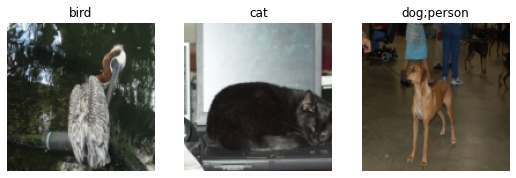

In [20]:
dls.show_batch(nrows=1, ncols=3)

Binary cross entropy

In [22]:
learn = cnn_learner(dls, resnet18)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
x, y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

RuntimeError: ignored

In [24]:
def binary_crossentropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  "Compute accuracy when inp and targ are the same size"
  if sigmoid:
    inp =inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [25]:
def say_hello(name, say_what="hello"):
  return f"{say_what} {name}."

say_hello('Jeremy'), say_hello('Jeremy', 'Hi')

('hello Jeremy.', 'Hi Jeremy.')

In [26]:
f=partial(say_hello, say_what="Bonjour")
f('Jeremy')

'Bonjour Jeremy.'

In [27]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))

learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.943363,0.702756,0.237669,00:46
1,0.826726,0.562374,0.295299,00:42
2,0.606372,0.198172,0.824940,00:45
3,0.361112,0.122655,0.940618,00:45


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.133656,0.120753,0.939582,00:48
1,0.115511,0.108692,0.952550,00:45
2,0.096991,0.105473,0.952350,00:47


In [28]:
learn.metrics = partial(accuracy_multi, thresh=0.1)

learn.validate()

(#2) [0.10547278821468353,0.9323306679725647]

In [29]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10547278821468353,0.9442033767700195]

In [30]:
preds, targs = learn.get_preds()

In [31]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9566)

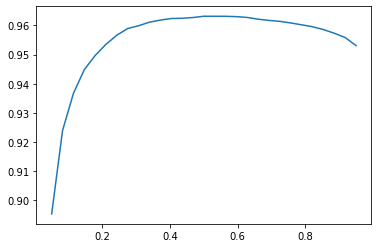

In [32]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

REGRESSION

In [33]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [34]:
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/io_sample.cpp'),Path('/root/.fastai/data/biwi_head_pose/20'),Path('/root/.fastai/data/biwi_head_pose/21.obj'),Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/12.obj'),Path('/root/.fastai/data/biwi_head_pose/01'),Path('/root/.fastai/data/biwi_head_pose/10.obj'),Path('/root/.fastai/data/biwi_head_pose/12'),Path('/root/.fastai/data/biwi_head_pose/24.obj'),Path('/root/.fastai/data/biwi_head_pose/07.obj')...]

In [35]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00279_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00117_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00040_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00082_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00424_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00179_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00238_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00366_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00222_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00029_pose.txt')...]

In [41]:
img_files = get_image_files(path)

def img2pose(x):
  return Path(f'{str(x)[:-7]}pose.txt')

img2pose(img_files[0])


Path('/root/.fastai/data/biwi_head_pose/20/frame_00040_pose.txt')

In [37]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

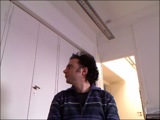

In [38]:
im.to_thumb(160)

In [39]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] *cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] *cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [42]:
get_ctr(img_files[0])

tensor([304.1663, 279.4590])

In [43]:
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]
)

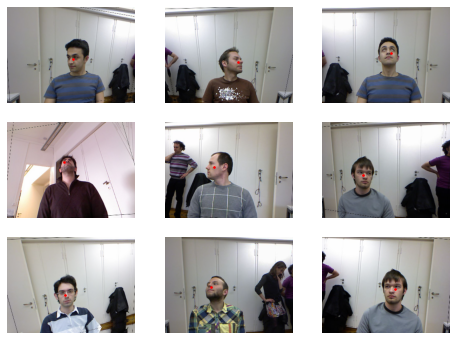

In [44]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))


In [45]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [46]:
yb[0]

TensorPoint([[-0.0054,  0.1440]], device='cuda:0')

Training a model

In [47]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:287: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
def sigmoid_range(x, lo, hi):
  return torch.sigmoid(x)*(hi-lo)+lo

In [49]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0014454397605732083)

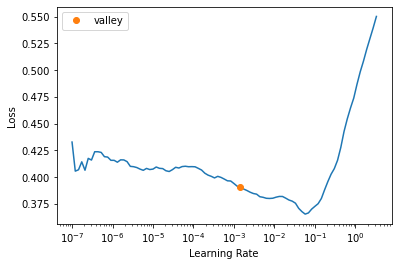

In [50]:
learn.lr_find()

In [51]:
lr=1e-2
learn.fine_tune(3,lr)

epoch,train_loss,valid_loss,time
0,0.048964,0.019685,02:02


epoch,train_loss,valid_loss,time
0,0.009076,0.007223,02:03
1,0.002932,0.000297,02:05
2,0.001369,0.000044,02:05


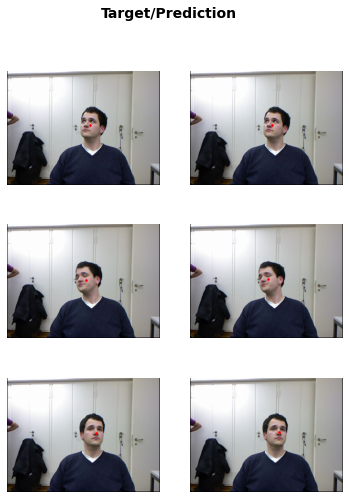

In [52]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))